In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [24]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

In [25]:
# merger.convert_deaths_df()
df = merger.merge_deaths_df()

In [26]:
df.tail()

,Sorszám,Nem,Kor,Alapbetegségek,date
4667,5,F,68,szív és érrendszeri,2020-11-29
4668,4,F,79,szív és érrendszeri,2020-11-29
4669,3,F,74,szív és érrendszeri,2020-11-29
4670,2,N,65,rosszindulatú daganat,2020-11-29
4671,1,N,76,szív és érrendszeri,2020-11-29


In [27]:
df_additional = merger.df["details"][["date","additional.infected"]].set_index("date")

In [28]:
df_tests = merger.show_kpi_hu()[["tests"]].reset_index()
df_tests["index"] = pd.to_datetime(df_tests["index"], format='%Y-%m-%d').dt.date
df_tests["additional.tests"] = df_tests.apply(
    lambda row: row["tests"]-df_tests[
        df_tests["index"]==row["index"] - pd.Timedelta(1, unit='D')
    ]["tests"].max(), 
    axis=1
)
df_tests = df_tests.set_index("index")

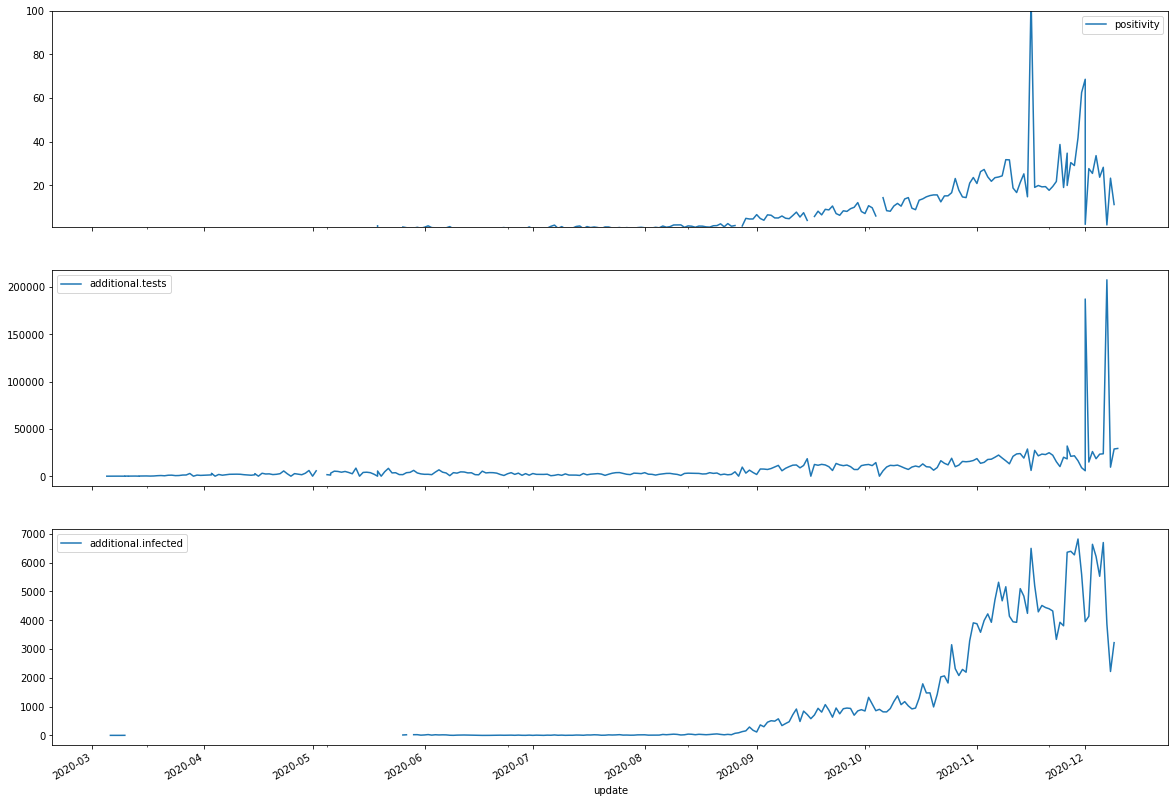

In [29]:
df_join = df_tests.join(df_additional).reset_index()
df_join["positivity"] = df_join["additional.infected"]/df_join["additional.tests"]*100
df_join["Country/Region"] = "HU"
df_join["update"] = df_join["index"]
(fig, ax) = plt.subplots(figsize=(20,15), nrows=3, sharex=True)
ax[0].set_ylim(1,100)
df_join.plot(x="update", y="positivity", ax=ax[0])
df_join.plot(x="update", y="additional.tests", ax=ax[1])
df_join.plot(x="update", y="additional.infected", ax=ax[2])
plt.show()

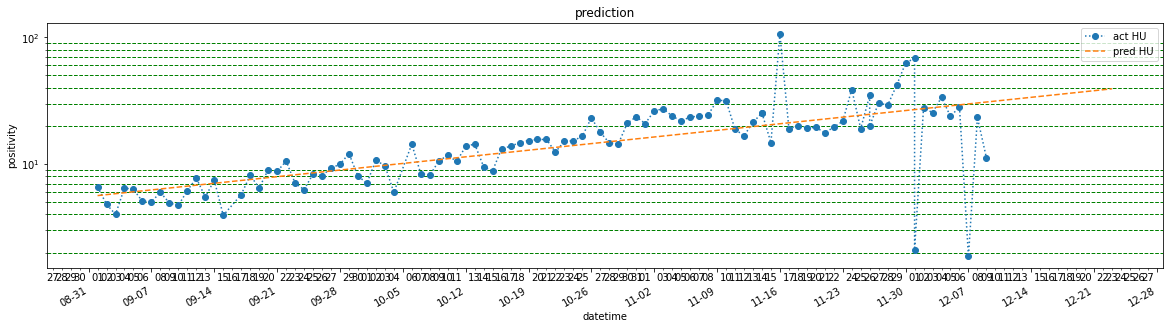

Coefficient of determination: {'HU': 0.5003493053986187}
Evolution factor per day: {'HU': 1.0}
Doubling in day(s): {'HU': 2.0}


,index,tests,additional.tests,additional.infected,positivity,Country/Region,update
316,2020-12-06,1941724.0,23681.0,6697.0,28.280056,HU,2020-12-06
317,2020-12-07,2149291.0,207567.0,3870.0,1.864458,HU,2020-12-07
318,2020-12-08,2158818.0,9527.0,2219.0,23.291697,HU,2020-12-08
319,2020-12-09,2187555.0,28737.0,3221.0,11.208546,HU,2020-12-09
320,2020-12-10,2216880.0,29325.0,NaN,NaN,HU,2020-12-10


In [30]:
tmpDf = md.DataProcessing.Analyse.start_analyse(
    df_join[
        (df_join["additional.tests"]>0) & (df_join["index"]>=pd.Timestamp("2020-09-01"))
    ].dropna(),
    ["HU"],
    "positivity", 
    "positivity"
)
df_join.tail()

# Check plausibility

In [31]:
merger.df["details"].columns

Index(['date', 'baseUrl', 'source', 'additional.infected',
       'cumulated.infected', 'additional.deaths',
       'cumulated.recoveredFromHospital', 'cumulated.deaths', 'onVentilator',
       'hospital', 'active.infectedBp%', 'cumulated.deathsBp%',
       'cumulated.recoveredBp%', 'active.infected', 'comment',
       'active.details_active.Bács-Kiskun', 'active.details_active.Baranya',
       'active.details_active.Békés',
       'active.details_active.Borsod-Abaúj-Zemplén',
       'active.details_active.Budapest', 'active.details_active.Csongrád',
       'active.details_active.Fejér',
       'active.details_active.Győr-Moson-Sopron',
       'active.details_active.Hajdú-Bihar', 'active.details_active.Heves',
       'active.details_active.Jász-Nagykun-Szolnok',
       'active.details_active.Komárom-Esztergom',
       'active.details_active.Nógrád', 'active.details_active.Pest',
       'active.details_active.Somogy',
       'active.details_active.Szabolcs-Szatmár-Bereg',
       'active

In [32]:
selected_details_df = merger.df["details"][[
    "date", "additional.infected", "additional.deaths", 
    "cumulated.infected", "cumulated.recoveredFromHospital", 
    "onVentilator", "hospital", "active.infected"
]].copy()
selected_details_df.columns = [
    "date", "news.add.infected", "news.add.deaths", 
    "news.cum.infected", "news.cum.recovered", 
    "news.onVentilator", "news.hospital", "news.active"
]
selected_details_df["date"] = pd.to_datetime(selected_details_df["date"], format='%Y-%m-%d').dt.date
selected_details_df["news.add.recovered"] = selected_details_df.apply(
    lambda row: row["news.cum.recovered"] - selected_details_df[
        selected_details_df["date"]<row["date"]
    ]["news.cum.recovered"].max(), axis=1
)
selected_details_df = selected_details_df.set_index("date")

selected_kpi_df = merger.show_kpi_hu()[["infected"]].copy().reset_index()
selected_kpi_df.columns = ["date", "kpi.cum.infected"]
selected_kpi_df["date"] = pd.to_datetime(selected_kpi_df["date"], format='%Y-%m-%d').dt.date
selected_kpi_df = selected_kpi_df.set_index("date")

selected_details_df.join(selected_kpi_df).tail()

,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,kpi.cum.infected
date,,,,,,,,,
2020-12-05,5525.0,193.0,243581,70396.0,637.0,7695.0,167479.0,1871.0,243581.0
2020-12-06,6697.0,162.0,250278,71682.0,656.0,7709.0,172728.0,1286.0,250278.0
2020-12-07,3870.0,116.0,254148,74283.0,674.0,7932.0,173881.0,2601.0,254148.0
2020-12-08,2219.0,136.0,256367,75281.0,656.0,8045.0,174966.0,998.0,256367.0
2020-12-09,3221.0,160.0,259588,76270.0,661.0,7945.0,177038.0,989.0,259588.0


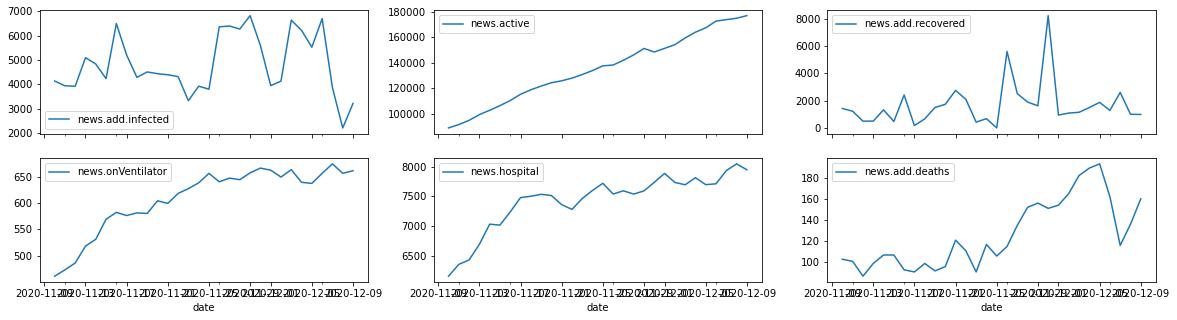

In [33]:
(fig, ax) = plt.subplots(figsize=(20,5), nrows=2, ncols=3, sharex=True)
plot_df = selected_details_df.reset_index().tail(30)
# 1st col
plot_df.plot(x="date", y="news.add.infected", ax=ax[0][0])
plot_df.plot(x="date", y="news.onVentilator", ax=ax[1][0])
# 2nd col
plot_df.plot(x="date", y="news.active", ax=ax[0][1])
plot_df.plot(x="date", y="news.hospital", ax=ax[1][1])
# 3rd col
plot_df.plot(x="date", y="news.add.recovered", ax=ax[0][2])
plot_df.plot(x="date", y="news.add.deaths", ax=ax[1][2])
plt.show()

In [34]:
baseDf = pd.read_csv("data/map_data/map_dataframe_per_megye.csv", delimiter=",")[['date','region','confirmed']]
# Convert date column and add week/dayofweek
baseDf['date'] =  pd.to_datetime(baseDf['date'], format='%Y-%m-%d')
baseDf[baseDf["date"].isin(["2020-12-01","2020-12-02","2020-12-03","2020-12-04","2020-12-05"])].pivot(
    index="region",
    columns="date",
    values="confirmed"
)

date,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05
region,,,,,
Baranya,5966,6083,6233,6423,6612
Borsod-Abaúj-Zemplén,13496,13733,14098,14387,14604
Budapest,47340,47985,48746,49680,50786
Bács-Kiskun,9719,9908,10177,10534,10759
Békés,6659,6811,7129,7429,7654
Csongrád,9360,9593,9966,10227,10462
Fejér,7469,7579,7859,8098,8279
Győr-Moson-Sopron,14384,14593,14917,15201,15479
Hajdú-Bihar,11900,12122,12544,12992,13335
